In [1]:
from collections import defaultdict

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd

from data import classification_dataset, kfolds, train_test_split
from train import train_model, train_model_with_early_stopping
from layers import SeluConv3D, SeluDense
from plot import plot_slice, plot_volume_animation
from config import (
    SPIE_SMALL_NEG_TFRECORD,
    SPIE_BIG_NEG_TFRECORD,
    SPIE_SMALL_POS_TFRECORD,
    SPIE_BIG_POS_TFRECORD,
    SMALL_PATCH_SHAPE,
    BIG_PATCH_SHAPE,
    SEED,
)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

tf.get_logger().setLevel("WARNING")

In [2]:
def build_3d_cnn():
    input_small = keras.Input(SMALL_PATCH_SHAPE, name="input_small")
    x_small = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="small_selu_conv3d_1",
    )(input_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_1")(x_small)
    x_small = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="small_selu_conv3d_2",
    )(x_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_2")(x_small)
    x_small = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="small_selu_conv3d_3",
    )(x_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_3")(x_small)
    x_small = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="small_selu_conv3d_4",
    )(x_small)
    x_small = keras.layers.Flatten(name="flatten_small")(x_small)

    input_big = keras.Input(BIG_PATCH_SHAPE, name="input_big")
    x_big = keras.layers.MaxPooling3D((2, 2, 2), name="big_maxpool_0")(input_big)
    x_big = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="big_selu_conv3d_1",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_1")(x_big)
    x_big = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="big_selu_conv3d_2",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_2")(x_big)
    x_big = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="big_selu_conv3d_3",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_3")(x_big)
    x_big = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="big_selu_conv3d_4",
    )(x_big)
    x_big = keras.layers.Flatten(name="flatten_big")(x_big)

    x = keras.layers.concatenate([x_small, x_big], name="concatenate")
    x = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(x)

    cnn_3d = keras.Model(inputs=[input_small, input_big], outputs=x, name="3dcnn")

    return cnn_3d

In [3]:
def build_pretrained_3d_cnn():
    cnn_3d = keras.models.load_model("models/lidc-3dcnn.h5")
    for layer in cnn_3d.layers:
        if "conv" in layer.name.lower():
            layer.trainable = False
    return cnn_3d

In [4]:
def build_3dcnn_with_pretrained_conv_layers():
    pretrained_cnn_3d = keras.models.load_model("models/lidc-3dcnn.h5")
    pretrained_cnn_3d.trainable = False
    x = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(
        pretrained_cnn_3d.layers[-2].output
    )
    return keras.Model(inputs=pretrained_cnn_3d.input, outputs=x)

In [5]:
def build_pretrained_3d_cnn_with_ae():
    small_encoder = keras.models.load_model("models/autoencoder-lidc.h5").get_layer(
        "encoder"
    )
    small_encoder._name = "small_encoder"
    for layer in small_encoder.layers:
        layer._name = "small_" + layer._name
    small_encoder.trainable = False

    input_small = keras.Input(SMALL_PATCH_SHAPE, name="input_small")
    x_small = small_encoder(input_small)
    x_small = keras.layers.Flatten(name="flatten_small")(x_small)

    big_encoder = keras.models.load_model("models/autoencoder-lidc.h5").get_layer(
        "encoder"
    )
    big_encoder._name = "big_encoder"
    for layer in big_encoder.layers:
        layer._name = "big_" + layer._name
    big_encoder.trainable = False

    input_big = keras.Input(BIG_PATCH_SHAPE, name="input_big")
    x_big = keras.layers.MaxPooling3D((2, 2, 2), name="big_maxpool_0")(input_big)
    x_big = big_encoder(x_big)
    x_big = keras.layers.Flatten(name="flatten_big")(x_big)

    x = keras.layers.concatenate([x_small, x_big], name="concatenate")

    x = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(x)

    cnn_3d = keras.Model(inputs=[input_small, input_big], outputs=x, name="3dcnn")

    return cnn_3d

In [6]:
metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.AUC(name="auc"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]

In [7]:
dataset, samples = classification_dataset(
    SPIE_SMALL_NEG_TFRECORD,
    SPIE_BIG_NEG_TFRECORD,
    SPIE_SMALL_POS_TFRECORD,
    SPIE_BIG_POS_TFRECORD,
    return_size=True,
)
samples

73

In [8]:
from collections import Counter

def count_labels(dataset):
    return Counter(label[0] for _, label in dataset.unbatch().as_numpy_iterator())

In [9]:
tries = 50
test_perc = 0.25
batch_size = 2
learning_rate = 1e-5
num_epochs = 10

In [10]:
data = defaultdict(list)
for _ in tqdm(range(tries)):
    full_train_dataset, test_dataset = train_test_split(
        dataset, test_perc=test_perc, seed=None
    )
    test_dataset = test_dataset.batch(batch_size)
    for frac in (1, 2, 3, 4, 5, 6, 7, 8, 9, 10):
        train_dataset = (
            full_train_dataset.shuffle(1024, reshuffle_each_iteration=False)
            .shard(num_shards=frac, index=0)
            .cache()  # must be called before shuffle
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )

        cnn = build_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.MeanSquaredError(),
            metrics=metrics,
        )
        cnn.fit(train_dataset, epochs=num_epochs, verbose=0)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("W/O pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
        data["nn_type"].append("W/O pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy")
        data["metric_value"].append(test_metrics["accuracy"])

        cnn = build_pretrained_3d_cnn()
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("W/ full pretraining; W/O finetuning")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
        data["nn_type"].append("W/ full pretraining; W/O finetuning")
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy")
        data["metric_value"].append(test_metrics["accuracy"])

        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.MeanSquaredError(),
            metrics=metrics,
        )
        cnn.fit(train_dataset, epochs=num_epochs, verbose=0)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("W/ full pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
        data["nn_type"].append("W/ full pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy")
        data["metric_value"].append(test_metrics["accuracy"])

        cnn = build_3dcnn_with_pretrained_conv_layers()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.MeanSquaredError(),
            metrics=metrics,
        )
        cnn.fit(train_dataset, epochs=num_epochs, verbose=0)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("W/ conv pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
        data["nn_type"].append("W/ conv pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy")
        data["metric_value"].append(test_metrics["accuracy"])

        cnn = build_pretrained_3d_cnn_with_ae()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.MeanSquaredError(),
            metrics=metrics,
        )
        cnn.fit(train_dataset, epochs=num_epochs, verbose=0)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("W/ AE pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
        data["nn_type"].append("W/ AE pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy")
        data["metric_value"].append(test_metrics["accuracy"])

df = pd.DataFrame(data)

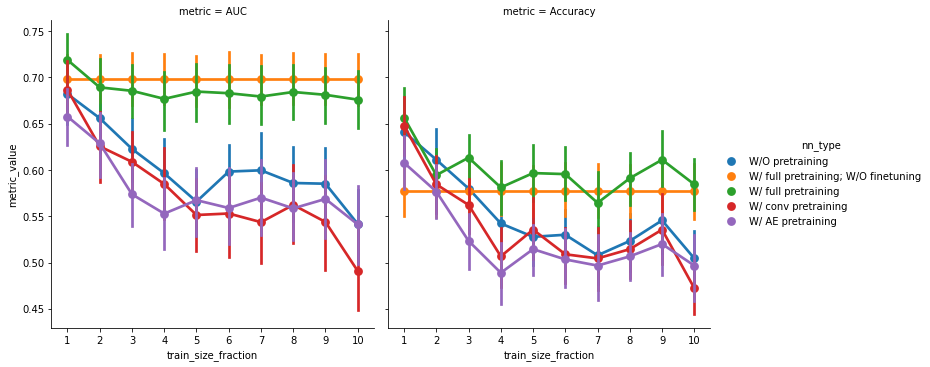

In [11]:
sns.catplot(
    x="train_size_fraction",
    y="metric_value",
    hue="nn_type",
    col="metric",
    kind="point",
    data=pd.DataFrame(data),
)